In [2]:
VERSION = "20200515"  #@param ["1.5" , "20200515", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  24790      0 --:--:-- --:--:-- --:--:-- 24790
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Uninstalling torch-1.5.1+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
\ [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
\ [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objec

In [3]:
!pip install --upgrade git+https://github.com/pytorch/contrib.git > /dev/null
!pip install transformers==2.5.1 > /dev/null
!pip install pandarallel > /dev/null
!pip install catalyst==20.4.2 > /dev/null
!pip install kaggle
!pip install emoji
!pip install num2words
# !pip install -U git+https://github.com/aboSamoor/polyglot.git@master
!pip install --upgrade language_tool_python
!pip install --upgrade turkishnlp

  Running command git clone -q https://github.com/pytorch/contrib.git /tmp/pip-req-build-qv7exn4o
     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=87a761ed25d528313683687526854bcfcf0052596fcc93c6376daddc675abecc
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 102kB 776kB/s 
  Created wheel for turkishnlp: filename=turkishnlp-0.0.61-cp36-none-any.whl size=7557 sha256=24ecc1df326133b3c2ac47df5436811376dbbb47ead53c53d18c403dc4932b23
  Stored in directory: /root/.cache/pip/wheels/06/11/95/9c04635b9b6cb20e8036e26a6cadaa86b32521a85155b6f1ca
Successfully built turkishnlp


In [3]:
# arr=[]
# while(1):
#  arr.append(1)

In [4]:
%load_ext autoreload
%autoreload 2 

from google.colab import drive

drive.mount("/content/drive", force_remount=True)

import sys
sys.path.append('drive/My Drive/toxic_comment/scripts')

import os
os.environ['XLA_USE_BF16'] = "1"

import gc
import time
import json
import random
from pathlib import Path
from importlib import reload

import utility as utils
import albumentations as alb
import data_cleaning as clean
import models
import config

reload(utils)
reload(alb)
reload(clean)
reload(models)
reload(config)


import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoConfig
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel

import torch
from torch.utils.data import DataLoader
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

pandarallel.initialize(nb_workers=16, progress_bar=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
root_dir = "drive/My Drive/toxic_comment"

# *Git related variables


GIT_REPOSITORY = "toxic-comment" 
GIT_CREDENTIALS = Path(root_dir, "credentials/git_creds.json")

def git_path():
  with open(GIT_CREDENTIALS) as cred_json:
    creds = json.load(cred_json)

  GIT_PATH = "https://" + creds['token'] + "@github.com/" + creds['username'] + "/" + GIT_REPOSITORY + ".git"
  print(f'GIT_PATH: {GIT_PATH}')

  return GIT_PATH, creds['email'], creds['username']

GIT_PATH, GIT_EMAIL, GIT_USERNAME = git_path()


# *Model related variables
SEED = 42
MODEL = 'xlm-roberta-large'
# the prefix used for identifiying pretrained language model layers
# in order to tune with different learning rate
MODEL_PREFIX = 'roberta'
MODEL_VERSION = 'v2'
MAX_LENGTH = 224

LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

# *Data access
data_dir = Path(root_dir, "data")
data_t_dir = data_dir/"jigsaw-toxic/translations"

# *Model paths
model_base_dir = Path(root_dir, "models")
model_dir = (model_base_dir/MODEL/MODEL_VERSION)

# *Files
train_file1 = "jigsaw-toxic/jigsaw-toxic-comment-train.csv"
train_file2 = "jigsaw-toxic/jigsaw-unintended-bias-train.csv"
val_file = "jigsaw-toxic/validation.csv"
val_file_translated1 = "jigsaw-toxic-comment-valid-yandex-en.csv"
val_file_translated2 = "jigsaw-toxic-comment-valid-google-en.csv"
test_file = "jigsaw-toxic/test.csv"
test_file_translated1 = "jigsaw-toxic-comment-test-yandex-en.csv"
test_file_translated2 = "jigsaw-toxic-comment-test-google-en.csv"
sub_file = "jigsaw-toxic/sample_submission.csv"
open_subtitles_file = 'open-subtitles-toxic/open-subtitles-synthesic.csv'

out_dir = Path(root_dir, 'output')

# this varibale indicates whether we are using fully english data pipeline
# in this pipeline, we are using english trasnlated validation test data
english_pipeline=False

# this parameter controls whether we are using multisample dropout or not for our NN model
output_hidden_states=True

In [ ]:
!git clone "{GIT_PATH}" ./temp      # clone github repository to temp folder
!mv ./temp/.git "{root_dir}/.git"       # move all files/folders in temp folder to folder defined in project path
!rm -rf ./temp                      # remove all the files/folders in temp folder

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    # xm.set_rng_state(seed) # new line

seed_everything(SEED)

In [8]:
%%time
# Read the data and external sources
dir_paths = {'base_dir': data_dir, 'base_t_dir': data_t_dir, 'train_file1': train_file1, 'train_file2': train_file2, 
             'val_file': val_file, 'val_file_translated1': val_file_translated1, 'val_file_translated2': val_file_translated2,
             'test_file': test_file, 'test_file_translated1': test_file_translated1, 'test_file_translated2': test_file_translated2,
             'sub_file': sub_file}
train, valid, test, sub = utils.read_data(dir_paths, list(LANGS.keys()), english_pipeline=english_pipeline)
external = utils.read_external_data((data_dir/'external'), list(LANGS.values()))

Translation has not found: drive/My Drive/toxic_comment/data/jigsaw-toxic/translations/jigsaw-toxic-comment-train-google-en-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/english-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/italian-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/french-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/spanish-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/russian-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/portuguese-external-cleaned.csv
CPU times: user 47.4 s, sys: 4.6 s, total: 52 s
Wall time: 1min 9s


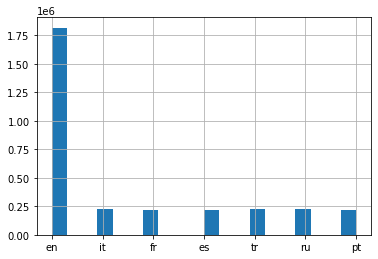

In [9]:
train['lang'].hist(bins=20);

In [10]:
train['comment_text'].isna().sum()

0

In [11]:
valid

,comment_text,lang,toxic
id,,,
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...
7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1


In [12]:
external.head(50)

,id,text,toxic,lang
0,20948,en güzel uyuyan insan ödülü jeon jungkooka gid...,0,tr
1,10134,mekanı cennet olsun saygılar sayın avukatımız...,0,tr
2,23457,kızlar aranızda kas yığını beylere düşenler ol...,0,tr
3,18401,biraz ders çalışayım tembellik ve uyku düşman...,0,tr
4,17525,trezeguet yerine el sharawy daha iyi olmaz mı,0,tr
5,11996,bence de olması gerekiyor hatta meslek lisesi...,0,tr
6,38452,mutlu görünümlü ama daima mutsuz olanlar burad...,0,tr
7,12615,liraya traş oldum arkadaşım diyor ki ne kesiyo...,0,tr
8,13520,reis bu ülkenin devlet başkanı ve ak parti gen...,1,tr
9,45562,var olan ancak düşünüldüğü kadarıyla vardır ...,0,tr


In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [14]:
input_cols_external = ['text']

external_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=external['toxic'].values, 
    comment_texts=external[input_cols_external].values, 
    langs=external['lang'].values,
    maxlen=MAX_LENGTH,
)

del external
gc.collect();

In [15]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,severe_toxicity,identity_attack,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,lang,Unnamed: 0,Unnamed: 0.1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223389,ffeb7faf9662ed0f,"(UTC)\n\n :: FYI, atualmente estou em conflito...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223544.0,223544.0
223390,ffe3a3e2d8f0eb9b,Esta é a minha sandbox da página de discussão ...,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223545.0,223545.0
223391,ffebe90c8d5acaba,"""\n\n == IRAN ==\n Isso mesmo, Irã. Foi o noss...",1,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223546.0,223546.0
223392,fff23c3e174e895e,"""\n li esta página de discussão e fiquei impre...",0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223547.0,223547.0


In [16]:
input_cols_dev = ['comment_text']

train_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=train['toxic'].values, 
    comment_texts=train[input_cols_dev].values, 
    langs=train['lang'].values,
    open_subtitles_path=data_dir/open_subtitles_file,
    maxlen=MAX_LENGTH,
    use_train_transforms=True,
)

del train
gc.collect();

In [17]:
validation_tune_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=valid['toxic'].values, 
    comment_texts=valid[input_cols_dev].values, 
    langs=valid['lang'].values,
    open_subtitles_path=data_dir/open_subtitles_file,
    maxlen=MAX_LENGTH,
    use_train_transforms=True,
)

valid = clean.clean_data(valid, input_cols_dev, True)

validation_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=valid['toxic'].values, 
    comment_texts=valid[input_cols_dev].values, 
    langs=valid['lang'].values,
    maxlen=MAX_LENGTH,
    use_train_transforms=False,
)

del valid
gc.collect();

In [18]:
# input_cols_test = ['content']
# test = clean.clean_data(test, input_cols_test)

# test_dataset = models.DatasetRetriever(
#     tokenizer,
#     labels_or_ids=test.index.values, 
#     comment_texts=test[input_cols_test].values, 
#     langs=test['lang'].values,
#     maxlen=MAX_LENGTH,
#     use_train_transforms=False,
#     test=True
# )

In [19]:
backbone_config = AutoConfig.from_pretrained(MODEL, output_hidden_states=output_hidden_states)
transformer = AutoModel.from_pretrained(MODEL, config=backbone_config)

In [20]:
net = models.ToxicSimpleNNModel(transformer, config.TrainGlobalConfig)

Multisample dropout is used.


In [21]:
net

ToxicSimpleNNModel(
  (backbone): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerN

In [22]:
import warnings
warnings.filterwarnings("ignore")

def _mp_fn(rank, flags):
    device = xm.xla_device()
    net.to(device)

    external_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=external_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    external_loader = torch.utils.data.DataLoader(
        external_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=external_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=config.TrainGlobalConfig.num_workers,
    )

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=config.TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    validation_tune_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_tune_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        validation_tune_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    # test_sampler = torch.utils.data.distributed.DistributedSampler(
    #     test_dataset,
    #     num_replicas=xm.xrt_world_size(),
    #     rank=xm.get_ordinal(),
    #     shuffle=False
    # )
    # test_loader = torch.utils.data.DataLoader(
    #     test_dataset,
    #     batch_size=config.TrainGlobalConfig.batch_size,
    #     sampler=test_sampler,
    #     pin_memory=False,
    #     drop_last=False,
    #     num_workers=config.TrainGlobalConfig.num_workers
    # )
    if rank == 0:
        time.sleep(1)
    
    config.TrainGlobalConfig.train_lenght = len(train_dataset)
    fitter = models.TPUFitter(model=net, device=device, config=config.TrainGlobalConfig, 
                              base_model_path=model_base_dir, model_name=MODEL, model_prefix=MODEL_PREFIX, 
                              model_version=MODEL_VERSION, out_path=out_dir, log_path=model_dir)
    fitter.fit(train_loader, validation_loader)
    # Tune the model with validation data (cleaned in the same way with validation data)
    fitter.run_validation_tuning(validation_loader, validation_tune_loader, config.TrainGlobalConfig.n_val_epoch)
    # xm.master_print(f'Tuning on external data: {val_epoch}')
    # fitter.run_validation_tuning(external_loader, val_epoch)
    # fitter.run_pseudolabeling(test_loader, val_epoch)

In [23]:
FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

TPUFitter started to initilized.
**** Directory structure created ****
Optimizer and scheduler started to initilized.
Number of training steps: 98408
Fitter prepared. Device is xla:1
**** Fitting process has been started ****

2020-06-20T11:39:41.898198
LR: 0.0 
Epoch:0
**** Epoch training has started: 0 ****
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 0.72386
Train Step 50, loss: 0.69312, final_score: 0.50749, time: 323.37109
Train Step 100, loss: 0.69406, final_score: 0.50348, time: 390.79306
Train Step 150, loss: 0.69484, final_score: 0.49517, time: 458.20658
Train Step 200, loss: 0.69234, final_score: 0.51701, time: 525.72463
Train Step 250, loss: 0.68923, final_score: 0.54024, time: 592.70205
Train Step 300, loss: 0.67974, final_score: 0.58431, time: 659.86913
Train Step 350, loss: 0.66100, final_score: 0.64063, time: 727.25311
Train Step 400, loss: 0.62769, final_score: 0.69966, time: 794.70554
Train Step 450, loss: 0.59737, final_score: 0.74581, time: 862.45378
Trai

In [24]:
tokenizer.save_pretrained(model_dir)
transformer.save_pretrained(model_dir)

In [25]:
config_path = (model_dir/"config.json")
# add model metadata for inference step
model_metadata = {'model_name': MODEL, "model_prefix": MODEL_PREFIX, "model_version": MODEL_VERSION, 
                  "max_len": MAX_LENGTH, "english pipeline": english_pipeline}

with open(config_path) as f:
    data = json.load(f)

data.update(model_metadata)

with open(config_path, 'w') as f:
    json.dump(data, f, indent=3, sort_keys=True)

In [26]:
with open(Path(root_dir, "credentials/kaggle.json")) as cred_json:
    creds = json.load(cred_json)

os.environ["KAGGLE_USERNAME"] = creds['username']
os.environ["KAGGLE_KEY"] = creds['key']

from kaggle.api.kaggle_api_extended import KaggleApi
new_model = {
  "title": f"{MODEL}", 
  "description": "Trained model for toxic comment challange",
  "id": f"quanncore/{MODEL.lower()}", 
  "licenses": [{"name": "CC0-1.0"}],
  "resources": [
    {
      "path": "best_model.bin",
      "description": "Saved model file"
    },
    {
      "path": "sentencepiece.bpe.model",
      "description": "sentencepiece model"
    },
    {
      "path": "special_tokens_map.json",
      "description": "Special token map"
    },
    {
      "path": "log.txt",
      "description": "Log file of trained model"
    },
    {
      "path": "tokenizer_config.json",
      "description": "Tokenizer config"
    },
    {
      "path": "config.json",
      "description": "Model config"
    }
  ],
}

def update_model_kaggle():
  api = KaggleApi()
  api.authenticate()

  dataset_id = f"quanncore/{MODEL.lower()}"
  with open((model_dir/'dataset-metadata.json'), 'w') as fp:
    json.dump(new_model, fp)
  
  response = api.dataset_status(dataset_id)
  if response == None:
    print('Creating a new dataset\n')
    api.dataset_create_new(model_dir)
  else:
    print(f'Got response: {response}\n. Creating a new version\n')
    api.dataset_create_version(model_dir, version_notes=f'new version: {MODEL_VERSION.lower()}')

In [27]:
update_model_kaggle()

  0%|          | 0.00/16.0 [00:00<?, ?B/s]

Got response: ready
. Creating a new version

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file tokenizer_config.json


100%|██████████| 16.0/16.0 [00:01<00:00, 13.3B/s]
  0%|          | 0.00/150 [00:00<?, ?B/s]

Upload successful: tokenizer_config.json (16B)
Starting upload for file special_tokens_map.json


100%|██████████| 150/150 [00:00<00:00, 188B/s]
  0%|          | 0.00/4.83M [00:00<?, ?B/s]

Upload successful: special_tokens_map.json (150B)
Starting upload for file sentencepiece.bpe.model


100%|██████████| 4.83M/4.83M [00:02<00:00, 2.38MB/s]
  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Upload successful: sentencepiece.bpe.model (5MB)
Starting upload for file pytorch_model.bin


100%|██████████| 2.09G/2.09G [00:30<00:00, 73.6MB/s]
  0%|          | 0.00/1.21k [00:00<?, ?B/s]

Upload successful: pytorch_model.bin (2GB)
Starting upload for file config.json


100%|██████████| 1.21k/1.21k [00:01<00:00, 636B/s]
  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Upload successful: config.json (1KB)
Starting upload for file best_model.bin


100%|██████████| 2.09G/2.09G [00:37<00:00, 59.6MB/s]
  0%|          | 0.00/157k [00:00<?, ?B/s]

Upload successful: best_model.bin (2GB)
Starting upload for file log.txt


100%|██████████| 157k/157k [00:01<00:00, 136kB/s]


Upload successful: log.txt (157KB)


In [1]:
%cd "{root_dir}"
!git status

[Errno 2] No such file or directory: '{root_dir}'
/content
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git add .

In [ ]:
# todo: please fill the lb score after making submission
git_comment = f'Model: {MODEL} Version: {MODEL_VERSION} Kaggle LB Score: {0.9301}'
!git commit -m "{git_comment}" -F "changes.txt"
!git config --global user.email "{GIT_EMAIL}"
!git config --global user.name "{GIT_USERNAME}"
!git push origin master